In [2]:
from torch.utils.data import DataLoader, random_split
from torch import cuda, tensor, nn, optim
from torchvision import transforms
import jax.numpy as jnp

import importlib
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
import numpy as np

import catdog_loader
from ptmodels import bic_pytorch as bp

# Use a gpu to train PyTorch networks if you have it.
pt_device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {pt_device}.')


Using cpu.


# Project One: Dog and Cat Classifier
The goal of this project is to use a kaggle dataset to train a dog and cat classifier.  The data consists of user images.  Because this is binary classification, we can probably get away with not doing one-hot encoding.  

Two classifiers will be implemented: one with JaX using flax, and the other with PyTorch.  Model archictures will be the same: a multilayer perceptron with relu activations for the hidden layers, and a sigmoid for the output layer.  The number of layers and nodes per layer will be the same between implementations, but said implementations should be flexible and not hardcode layer or node count. 

The first thing we need to do is load the data and format it for training. 

In [3]:
data_path = Path('datasets') / 'kagglecatsanddogs_5340' / 'PetImages'
cat_path = data_path / 'Cat'
dog_path = data_path / 'Dog'
cat_img_names = list(cat_path.glob('*.jpg'))
dog_img_names = list(dog_path.glob('*.jpg'))

def get_image(fname):
    assert Path(fname).is_file()
    return np.asarray(io.imread(fname), dtype=int)

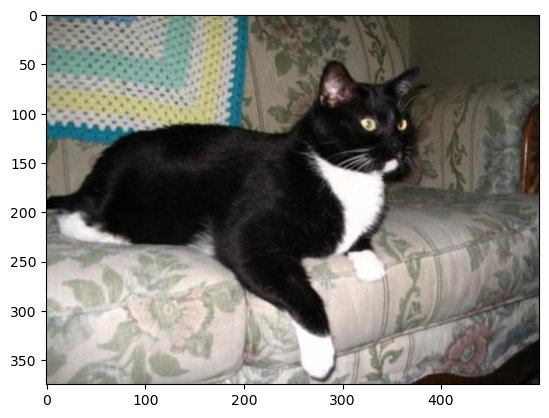

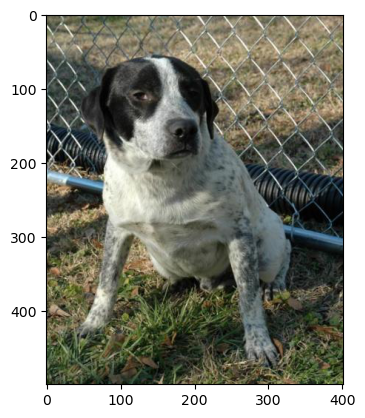

(375, 500, 3) (500, 401, 3)


In [4]:
# Testing get_image
cat_test = cat_img_names[1]
dog_test = dog_img_names[1]

cat_test_img = get_image(cat_test)
dog_test_img = get_image(dog_test)

plt.imshow(cat_test_img)
plt.show()
plt.imshow(dog_test_img)
plt.show()

print(cat_test_img.shape, dog_test_img.shape)

We already have an issue here --- the images are different shapes.  
To train a multilayer perceptron requires intputs to be the same sized vectors.  To resize the image will require an affine transformation, which preserves parallel lines.  
The math is not incredibly complicated, but stable implementations already exist with scikit-image, so we will use that package.  
Tensorflow and PyTorch also have modules for handling image prep/augmentation. 

We could also crop the images to the same size, which is not a bad idea --- it also kind of does some data augmentation that could help the classifier.  
If we really wanted to spice things up, we could also rotate/reflect these images to further augment the data set.  Naturally, we'd want the classifier to not overfit to particular orientations of animals, which people taking pictures might bias the network to think!  Let's leave that for another day, though. 

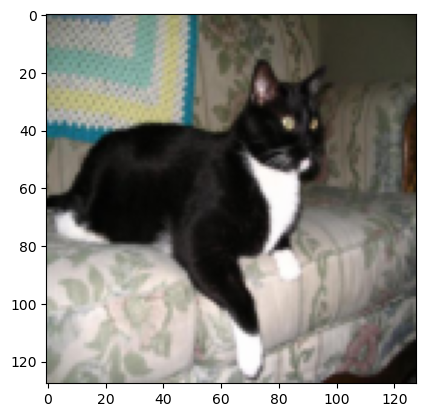

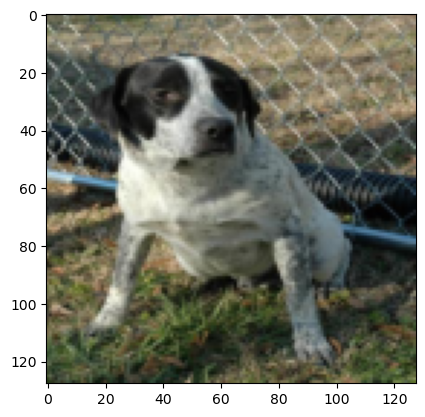

(128, 128, 3) (128, 128, 3)


In [5]:
def get_image_resize(fname, img_size=(128, 128)) -> np.ndarray:
    """ Takes a file and and loads it as an imag with given size. 

    Args:
        fname (str or Path): Path of image file. 
        img_size (tuple, optional): Image size in pixels. Defaults to (128, 128).

    Returns:
        numpy.ndarray: Image as an array. 
    """
    assert Path(fname).is_file()

    # Some files are corrupt, empty, or otherwise problematic. 
    try:
        raw_img = io.imread(fname)
    
    except ValueError:
        print(f'File {fname} raised ValueError. Skipping and returning None')
        return None

    return np.asarray(transform.resize(raw_img, img_size, anti_aliasing=True), dtype=float)

def strict_flatten(arr, size=None):
    """ Forcefully flattens incoming array. 

    Args:
        arr (numpy.ndarray): Array to flatten.
        # size (int, optional): Size of flattened array. Defaults to None.

    Returns:
        numpy.ndarray: Flattened array. 
    """
    arr_flat = arr.flatten()
    # if size:
    #     if arr_flat.shape[0] == size:
    #         return arr_flat
    
    return arr_flat

cat_test_img_resize = get_image_resize(cat_test)
dog_test_img_resize = get_image_resize(dog_test)

plt.imshow(cat_test_img_resize)
plt.show()
plt.imshow(dog_test_img_resize)
plt.show()

print(cat_test_img_resize.shape, cat_test_img_resize.shape) # We're in business!

Because this is a multiplayer perceptron, it is easiest to just flatten each image into a 1D vectors $\mathbf{x}$ of length 128 * 128 * 3. Since we are doing binary classification, we also mark dogs with $y=0$ and cats with $y=1$ to get $(\mathbf{x},y)$ pairs for training and validation. 

In [6]:
def get_onehot(y, n_class):
    """ One-hot mapping.

    Args:
        y (List or numpy.ndarray): incoming y values as a 1D iterable.
        n_class (int): Class number count. 

    Returns:
        numpy.ndarray: outgoing one-hot vector. 
    """
    y_arr = np.asarray(y)
    y_new = np.zeros((len(y), n_class))
    y_new[np.arange(len(y)), y_arr.astype(int)] = 1
    return y_new.reshape((len(y), n_class, 1))

def load_dataset(data_path, size=5000, onehot=False, img_size=(128, 128), include_path=False):
    """ This function first loads AND resizes images into a sample of size 'size', and then 

    Args:
        data_path (str or pathlib.Path): Path containing cat and dog image subdirectories.
        size (int, optional): Size of training set, split evenly between cats and dogs. Defaults
            to 5000.
        onehot (bool, optional): Use one-hot encoding. Defaults to False.
        img_size (tuple, optional): Size of the resized image. Defaults to (128, 128).
        include_path (bool, optional): Returns image file path with loaded image.  Convenient for 
            debugging. Defaults to False.

    Returns:
        _type_: _description_
    """
    cat_path = data_path / 'Cat'
    dog_path = data_path / 'Dog'
    
    # We will split the cat and dog subsamples to each be half the total data set.
    if size:
        nc = size // 2
        nd = size // 2

    # Length of x vector. 
    nx = img_size[0] * img_size[1] * 3

    # Lists of file names.
    cat_fname_list = list(cat_path.glob('*.jpg'))
    dog_fname_list = list(dog_path.glob('*.jpg'))

    # The next logic takes into account some images are not RGB color 
    # images, or are not 128x128 pixel images.  We still need size // 2 images
    # for both cats and dogs. 
    cat_imgs = []
    dog_imgs = []
    cat_imgs_name = []
    dog_imgs_name = []
    cc = 0
    cd = 1

    # For cats. 
    while True:
        # Grab a random image, resize and load it, and test and see if it is the
        # right size. 
        i_c = np.random.randint(0, len(cat_fname_list))
        c_cand = cat_fname_list[i_c]
        img = get_image_resize(c_cand, img_size=img_size)

        if img is None:
            # Get rid of img returning None.  Something is wrong with it. 
            cat_fname_list.pop(i_c)
        
        elif np.product(img.shape) == nx:
            # If it's the right size, then pop our that image from the list. 
            # We don't want it randomly selected again. 
            cat_fname_list.pop(i_c)
            cc += 1
            cat_imgs.append(img)
            cat_imgs_name.append(c_cand)
 
        if cc > nc:
            break

    # Same as above, but for dogs.
    while True:
        i_d = np.random.randint(0, len(dog_fname_list))
        d_cand = dog_fname_list[i_d]
        flat_image = strict_flatten(get_image_resize(d_cand, img_size=img_size), size=nx)

        if img is None:
            dog_fname_list.pop(i_d)
        
        if flat_image is not None:
            dog_fname_list.pop(i_d)
            cd += 1
            dog_imgs.append(flat_image)
            dog_imgs_name.append(d_cand)

        if cd > nd:
            break

    if onehot:
        f = lambda y: get_onehot(y, 2)
    else:
        f = lambda y: y

    if include_path:
        cat_imgs_ds = list(zip(cat_imgs_name, cat_imgs, f(np.ones((nc, 1)))))
        dog_imgs_ds = list(zip(dog_imgs_name, dog_imgs, f(np.zeros((nd, 1)))))
    
    else:
        cat_imgs_ds = list(zip(cat_imgs, f(np.ones((nc, 1)))))
        dog_imgs_ds = list(zip(dog_imgs, f(np.zeros((nd, 1)))))
        
    return cat_imgs_ds + dog_imgs_ds

test_ds = load_dataset(data_path, size=10, onehot=True)
print(test_ds[0][1]) # one hot encoding is working if we want it!
test_ds[0][0].shape, 128 * 128 * 3 # looks good so far

[[0.]
 [1.]]


/var/folders/1v/2wqw3rzx3qg41mbj638bc10c0000gn/T/ipykernel_38393/3958519894.py:112: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  test_ds = load_dataset(data_path, size=10, onehot=True)


((128, 128, 3), 49152)

The functionality above so far works, but is becoming increasingly unwieldy.  There are couple criticism to share.  First, `load_dataset` loads all images into memory in an incredibly inefficient way.  Second, the transformations have effectively been split between two points in the workflow, a poor design choice in hindsight.  Specifically, when an image is loaded with `get_image_resize`, we are also transforming the image by resizing it.  This is partly necessary because we cannot chain sequential transformations together in `load_dataset`'s current form. 

There is another issue.  Right now, we are simultaneously trying to handle bad or incompatible images while loading images into the data set.  This intermixing of two distinct objectives into one function call makes `load_dataset` quite opaque and obtuse.  Instead, we could do a one-time check for bad/incompatible images, and remove them before we even consider how to load the data set. After that, we can think about an improved data set loading procedure. 

We are going to be moving incompatible, corrupt, or bad images to two new directories: `PetImages/notused_cat` and `PetImages/notused_dog`.  It is good practice to not immediately delete problematic data -- for example, you can always come back to it and see if you can transform incompatible file types to increase your training set if you need to!

In [6]:
# we are just going to script this workflow since it is a one-time thing. 

notused_cat_path = data_path / 'notused_cat'
notused_dog_path = data_path / 'notused_dog'

notused_cat_path.mkdir(exist_ok=True)
notused_dog_path.mkdir(exist_ok=True)

dont_use_cat = []
for f in cat_path.glob('*.jpg'):
    try:
        # First, we load an image and see if it fails.  If it does,
        # then we add it to the don't use list. 
        arr = io.imread(str(f))

        # Also, if there are not three color channels, we also are 
        # going to move the file. 
        if arr.shape[-1] != 3:
            dont_use_cat.append(f)
    
    except:
        print(f'{f} raised exception when read.  Skipping...')
        dont_use_cat.append(f)


dont_use_dog = []
for f in dog_path.glob('*.jpg'):
    try:
        # First, we load an image and see if it fails.  If it does,
        # then we add it to the don't use list. 
        arr = io.imread(str(f))

        # Also, if there are not three color channels, we also are 
        # going to move the file. 
        if arr.shape[-1] != 3:
            dont_use_dog.append(f)
    
    except:
        dont_use_dog.append(f)


/Users/jaredhand/opt/miniconda3/envs/deeplearning_class/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [37]:
# len(dont_use_cat), len(dont_use_dog)

(0, 0)

In [22]:
# It took a minute to go through all the images.  Now we move them 
# to the new 'not used' directories. 
for f in dont_use_cat:
    new_path = notused_cat_path / f.name
    shutil.copy(f, new_path)
    f.unlink() # easy way to remove a file located at the path 'f'. 

for f in dont_use_dog:
    new_path = notused_dog_path / f.name
    shutil.copy(f, new_path)
    f.unlink()

We have saved troublesome images to look at later if we are so obliged. Let's come back to loading the data set.  As mentioned, we are running into some design issues in our current implementation. Instead of implementing this functionality nearly from scratch, let's use PyTorch's DataSet and DataLoader classes.  The file `catdog_loader.py` contains a DataSet subclass `CatDogDataSet` which we can use to load up the data set.  We can also use `torchvision.transforms` transformations to chain image transformations together for our input image Tensors and outputs.  

In [54]:
importlib.reload(catdog_loader)
pt_transforms = transforms.Compose([transforms.Resize((128, 128), antialias=True)])

data_pt = catdog_loader.CatDogDataSet(
    data_path, transform=pt_transforms
)

# If we want one-hot encoding, we could do this using the 'target_transform' kwarg.  Just make sure 
# to specify the number of classes for the encoding. A lambda function will work well to do that here. 
# data_pt = catdog_loader.CatDogDataSet(
#     data_path, transform=pt_transforms, target_transform=lambda x: nn.functional.one_hot(x, num_classes=2)
# )
data_pt.__getitem__(0)[1].float()
    

tensor(1.)

Already, we see the advantage of not reinventing the wheel.  PyTorch and torchvision provide powerful tools to pre-process, load, and transform data.  Unless otherwise noted, they are tried modules with robust support.  We will stick with PyTorch IO for the remainder of this notebook. 

Next, we want to prepare the data set to be fed forward through the networks we will be using.  First, we are going to split the data into random subsamples --- one for training, the other for testing. Again, PyTorch makes this easy by providing an easy way to do this with `torch.utils.data.random_split`.  After that, we are going to prepare the data for network feed forward by using the `DataLoader` class.  It makes it easy to create random batches of specified size from a `DataSet` object (specifically, the `CatDogDataSet` object we wrote).   

In [77]:
data_train, data_valid = random_split(data_pt, [0.8, 0.2])
dataload_train = DataLoader(data_train, batch_size=64, shuffle=True)
dataload_valid = DataLoader(data_valid, batch_size=64, shuffle=True)

We are set to start training some networks.  Let's start with a PyTorch implementation of a single layer linear network with a sigmoid activation function.  This is equivalent to logistics classification.  Any neural network training workflow requires we specify a model, a loss function, and an optimizer.  We'll do that now, along with specifying some hyperparameters. 

In [103]:
importlib.reload(bp)
# Number of epochs and learning rate for optimizer. 
n_epochs = 3
lr = 1e-3

# When instantiating the PyTorch logistic classifier model, we can also tell it to use 
# the specified device to train.  If you have a GPU, this is an easy way to use it.
pt_logistic = bp.Logistic(n_in=128 * 128 * 3).to(pt_device)

# Since this is a binary classification problem, we use the cross entropy loss function. 
# Note that 'cross_entropy' is a function, so don't add () at the end here!
pt_log_loss = nn.functional.binary_cross_entropy

# The optimizer will always need the model parameters as input.  This makes sense --- 
# you can't optimize a model without changing the model parameters!
pt_log_opt = optim.SGD(pt_logistic.parameters(), lr=lr)


In [98]:
bp.reset_params(pt_logistic)

v_loss = bp.train_bic_model(dataload_train, dataload_valid, pt_logistic, pt_log_opt, pt_log_loss, n_epochs)

Batch [   64/19981] loss: 0.699774.
Batch [ 1664/19981] loss: 1.184958.
Batch [ 3264/19981] loss: 0.769947.
Batch [ 4864/19981] loss: 1.270382.
Batch [ 6464/19981] loss: 0.665342.
Batch [ 8064/19981] loss: 0.944203.
Batch [ 9664/19981] loss: 1.011589.
Batch [11264/19981] loss: 0.716014.
Batch [12864/19981] loss: 1.154878.
Batch [14464/19981] loss: 1.368226.
Batch [16064/19981] loss: 0.942398.
Batch [17664/19981] loss: 1.105393.
Batch [19264/19981] loss: 2.061698.
Epoch 0 validation loss: 0.012706.
---------------------------------------
Batch [   64/19981] loss: 0.876642.
Batch [ 1664/19981] loss: 1.383817.
Batch [ 3264/19981] loss: 1.038241.
Batch [ 4864/19981] loss: 0.681466.
Batch [ 6464/19981] loss: 0.956637.
Batch [ 8064/19981] loss: 0.787971.
Batch [ 9664/19981] loss: 0.802989.
Batch [11264/19981] loss: 0.894244.
Batch [12864/19981] loss: 0.719094.
Batch [14464/19981] loss: 0.719640.
Batch [16064/19981] loss: 0.803745.
Batch [17664/19981] loss: 1.070450.
Batch [19264/19981] loss:

In [99]:
from torch import unsqueeze

for i in range(15):
    test_image, test_label = data_valid.__getitem__(i)
    print(pt_logistic(unsqueeze(test_image, 0)), test_label)

pt_logistic.get_parameter()

tensor(0.2061, grad_fn=<SqueezeBackward0>) tensor(1)
tensor(0.2350, grad_fn=<SqueezeBackward0>) tensor(1)
tensor(0.1888, grad_fn=<SqueezeBackward0>) tensor(1)
tensor(0.5795, grad_fn=<SqueezeBackward0>) tensor(1)
tensor(0.6632, grad_fn=<SqueezeBackward0>) tensor(1)
tensor(0.8344, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.6051, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.7438, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.3475, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.6078, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.4222, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.3222, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.4795, grad_fn=<SqueezeBackward0>) tensor(1)
tensor(0.3059, grad_fn=<SqueezeBackward0>) tensor(0)
tensor(0.7290, grad_fn=<SqueezeBackward0>) tensor(0)


TypeError: get_parameter() missing 1 required positional argument: 'target'